In [1]:
cd '/home/dpirvu/DarkPhoton/'

/home/dpirvu/DarkPhoton


In [2]:
import os,sys
sys.path.remove('/home/dpirvu/DarkPhotonxunWISE/hmvec-master')
sys.path.append('/home/dpirvu/DarkPhoton/hmvec-master/')
sys.path.append('/home/dpirvu/python_stuff/')
print(sys.path)

import hmvec as hm

from plotting import *
from compute_power_spectra import *
from params import *

%matplotlib inline

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


['/home/dpirvu/DarkPhoton', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython', '/home/dpirvu/DarkPhoton/hmvec-master/', '/home/dpirvu/python_stuff/']


In [3]:
ellMax = 7000
ells = np.arange(ellMax)

getgas = True
dictKey = dictKey_gas
model = modelParams_gas
print(len(dictKey), dictKey)

rscale = False

allcols = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
cych = cycle(allcols)

varep= 1.e-7

baseline = ghztoev(30)
units = xov(baseline) / baseline

ztype = [2., 6.]
zreio = 6.

zMin = 0.01
zMax = zreio

nZs  = 50
nMs  = 100

nspec  = 4
nfreqs = 9

rs  = np.linspace(1e-6, 1e2, 10000)              # halo radius

compute_BB_noise = False
compute_noise = False
get_constr = False
get_hm = False

fsky = [0.7, 0.5, 0.5]

48 [1.3e-13 1.5e-13 1.7e-13 1.9e-13 2.0e-13 2.2e-13 2.4e-13 2.6e-13 2.8e-13
 3.0e-13 3.2e-13 3.4e-13 3.6e-13 3.8e-13 4.0e-13 4.2e-13 4.4e-13 4.6e-13
 4.8e-13 5.0e-13 5.2e-13 5.4e-13 5.6e-13 5.8e-13 6.0e-13 6.2e-13 6.4e-13
 6.6e-13 6.8e-13 7.0e-13 7.5e-13 8.0e-13 9.0e-13 1.0e-12 1.2e-12 1.4e-12
 1.6e-12 1.8e-12 2.0e-12 2.5e-12 3.0e-12 3.5e-12 4.0e-12 5.0e-12 6.0e-12
 7.0e-12 8.0e-12 1.0e-11]


In [4]:
if get_hm:
    ms  = np.geomspace(1e11,1e17,100)       # masses
    zs  = np.linspace(zMin, zMax,nZs)       # redshifts
    ks  = np.geomspace(1e-4,1e3, 1001)      # wavenumbers

    # Halo Model
    dictnumber= 21
    unWISEcol = 'blue'
    pathdndz  = "/home/dpirvu/DarkPhotonxunWISE/dataHOD/normalised_dndz_cosmos_0.txt"
    hod_name  = "unWISE"+unWISEcol

    hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir', concmode='duffy')#, unwise_color=unWISEcol, choose_dict=dictnumber)
    #hcos.add_hod(name=hod_name)
    print('Test hmvec')
    print(hm.default_params['H0'])
    print(hcos.conc)

    chis     = hcos.comoving_radial_distance(zs)
    rvirs    = hcos.rvir(ms[None,:],zs[:,None])
    cs       = hcos.concentration()
    Hz       = hcos.h_of_z(zs)
    nzm      = hcos.get_nzm()
    biases   = hcos.get_bh()
    deltav   = hcos.deltav(zs)
    rhocritz = hcos.rho_critical_z(zs)
    m200c, r200c = get_200critz(zs, ms, cs, rhocritz, deltav)
    dvols  = get_volume_conv(chis, Hz)

    PzkLin = hcos._get_matter_power(zs, ks, nonlinear=False)
    Pzell  = get_fourier_to_multipole_Pkz(zs, ks, chis, ellMax, PzkLin)
    Pzell0 = Pzell.transpose(1,0)
    print('Done turning into multipoles.')

    print('Importing base CMB PS and adding T monopole.')
    CMB_ps        = hcos.CMB_power_spectra()
    lensedCMB     = CMB_ps['lensed_scalar']
    lensedCMB     = lensedCMB[:ellMax, :]
    lensedCMB[0,0]= TCMB**2.


In [5]:
tauMWlist = np.zeros(len(dictKey))
avtaulist = np.zeros((len(ztype), len(dictKey_NFW))) 
dtaudzlist, zsList = np.zeros((2, len(ztype), len(dictKey), nZs))
Cell1Hdata, Cell2Hdata, CellTauTau = np.zeros((3, len(ztype), len(dictKey), ellMax))
Screening = np.zeros((len(ztype), len(dictKey), 4, ellMax))
Survey = np.zeros((len(dictKey), ellMax))
rcrossdata = np.zeros((len(ztype), len(dictKey), nZs, nMs))

for mind, MA in enumerate(dictKey):
    for zind, ztest in enumerate(ztype):

        zMin, zMax, rMin, rMax = chooseModel(MA, model)
        zMax = min(ztest, zMax)
        
        try:
            data = import_data(MA, nZs, zMin, zMax, ellMax, getgas, rscale)
            rcrossMW, probMW, rcross, prob, avtau, dtaudz, uell0, Cell1H, Cell2H, CMBDP = data
        except:
            print(zind, mind, ztest, MA)
            continue

        rcrossdata[zind, mind] = rcross

        avtaulist[zind, mind]  = avtau  * units
        dtaudzlist[zind, mind] = dtaudz * units
        tauMWlist[mind]        = probMW * units
        zsList[zind, mind]     = np.linspace(zMin,zMax,nZs)

        Cell1Hdata[zind, mind] = Cell1H * units**2.
        Cell2Hdata[zind, mind] = Cell2H * units**2.
        CellTauTau[zind, mind] = Cell1Hdata[zind, mind] + Cell2Hdata[zind, mind]
        Screening[zind, mind]  = CMBDP * units**2.

for mind, MA in enumerate(dictKey):
    Survey[mind] = Cell1Hdata[0, mind] + Cell2Hdata[0, mind]


In [6]:
data = import_data_thomson(nZs, 0.005, zreio, ellMax, getgas, rscale)
prob_thom, thom_Cell1Hdata, thom_Cell2Hdata, thom_Screening = data
tauTh = 0.06
CellThomThom = (thom_Cell1Hdata + thom_Cell2Hdata) / tauTh**2.
thom_Screening/=tauTh

In [7]:
cross_Cell1H, cross_Cell2H, cross_CellTTau = np.zeros((3, len(dictKey), ellMax))
cross_Screening = np.zeros((len(dictKey), 4, ellMax))
bispTTT, bispTEB = np.ones((2, len(dictKey), 3))

for mind, MA in enumerate(dictKey):
    zMin, zMax, rMin, rMax = chooseModel(MA, model)
    zreio = 6.
    zMax = min(zreio, zMax)

    data = import_data_thomsoncrosstau(MA, nZs, 0.005, zMax, ellMax, getgas, rscale)
    crossCell1H, crossCell2H, crossCMBDP = data

    cross_Cell1H[mind] = crossCell1H * units
    cross_Cell2H[mind] = crossCell2H * units
    cross_CellTTau[mind]  = cross_Cell1H[mind] + cross_Cell2H[mind]
    cross_Screening[mind] = crossCMBDP * units

    for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
        path_bispTTT = path_bispTdscTscTsc_gas(MA, nZs, 0.005, zMax, ellMax, rscale, expname)
        path_bispTEB = path_bispTdscEscBsc_gas(MA, nZs, 0.005, zMax, ellMax, rscale, expname)

        try:
            bispTTT[mind, eind] = np.load(path_bispTTT)
            bispTEB[mind, eind] = np.load(path_bispTEB)
        except:
            continue

In [8]:
NFW_tauMWlist = np.zeros(len(dictKey_NFW))
NFW_avtaulist = np.zeros((len(ztype), len(dictKey_NFW))) 
NFW_dtaudzlist, NFW_zsList = np.zeros((2, len(ztype), len(dictKey_NFW), nZs))
NFW_Cell1Hdata, NFW_Cell2Hdata, NFW_CellTauTau = np.zeros((3, len(ztype), len(dictKey_NFW), ellMax))
NFW_Screening = np.zeros((len(ztype), len(dictKey_NFW), 4, ellMax))
NFW_Survey = np.zeros((len(dictKey_NFW), ellMax))

NFW_rcrossdata = np.zeros((len(ztype), len(dictKey), nZs, nMs))

for mind, MA in enumerate(dictKey_NFW):
    for zind, zreio in enumerate(ztype):
        zMin, zMax, rMin, rMax = chooseModel(MA, modelParams_NFW)
        zMax = min(zreio, zMax)

        try:
            data = import_data(MA, nZs, zMin, zMax, ellMax, getgas=False, rscale=True)
            rcrossMW, probMW, rcross, prob, avtau, dtaudz, uell0, Cell1H, Cell2H, CMBDP = data
        except:
            print(zind, mind, ztest, MA)
            continue
            
        NFW_rcrossdata[zind, mind] = rcross

        NFW_dtaudzlist[zind, mind] = dtaudz * units
        NFW_avtaulist[zind, mind]  = avtau * units
        NFW_tauMWlist[mind]    = probMW * units
        NFW_zsList[zind, mind] = np.linspace(zMin,zMax,nZs)

        NFW_Cell1Hdata[zind, mind] = Cell1H * units**2.
        NFW_Cell2Hdata[zind, mind] = Cell2H * units**2.
        NFW_CellTauTau[zind, mind] = NFW_Cell1Hdata[zind, mind] + NFW_Cell2Hdata[zind, mind]
        NFW_Screening[zind, mind]  = CMBDP * units**2.

for mind, MA in enumerate(dictKey_NFW):
    NFW_Survey[mind] = NFW_Cell1Hdata[0, mind] + NFW_Cell2Hdata[0, mind]


In [9]:
if False:
    fullzs = np.linspace(0.01, 6., 50)
    partzs = [fullzs[0], fullzs[8], fullzs[16], fullzs[25], fullzs[-1]]
    lists = np.array([[ii, jj] for ii, jj in zip(partzs[:-1], partzs[1:])]); print(lists)

    mlists = np.array([[mind, MA] for mind, MA in enumerate(dictKey_NFW)])

    HV2Mpc3 = lambda HV: 1e10*HV
    ms = np.geomspace(1e11,1e17,100)        # masses
    ks = np.geomspace(1e-4,1e3,11)          # wavenumbers

    xdat, ydat = np.ones((2, len(lists), len(mlists)))
    for a1, (zmin, zmax) in enumerate(lists):
        for a2, (mind, MA) in enumerate(mlists):

            mind = int(mind); print(mind, MA)

            # the redshifts relevant for conversion of dark photon of fixed mass m_A
            zsss = NFW_zsList[1, mind, :]

            zs    = np.linspace(zsss[0],zsss[-1],50)    # redshifts
            hcos  = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir', concmode='duffy')
            nzm   = hcos.get_nzm()

            # the physical redshift range of interest
            zi = (zs>=zmin) & (zs<zmax)

            # total number of halos within redshift range
            Ntot = np.trapz(np.trapz(nzm[zi, :], ms, axis=-1), zs[zi], axis=0); print('# halos', Ntot)

            # average r_cross weighted by the number density
            ydat[a1, a2] = np.trapz(np.trapz(NFW_rcrossdata[1, mind, zi, :] * nzm[zi, :], ms, axis=-1), zs[zi], axis=0) / Ntot
            xdat[a1, a2] = dictKey_NFW[mind]

    np.save('./data/NFW_rss_rresdat.npy', [lists, mlists, xdat, ydat])

if False:
    fullzs = np.linspace(0.01, 6., 50)
    partzs = [fullzs[0], fullzs[8], fullzs[16], fullzs[25], fullzs[-1]]
    lists = np.array([[ii, jj] for ii, jj in zip(partzs[:-1], partzs[1:])]); print(lists)

    mlists = np.array([[mind, MA] for mind, MA in enumerate(dictKey)])

    HV2Mpc3 = lambda HV: 1e10*HV
    ms = np.geomspace(1e11,1e17,100)        # masses
    ks = np.geomspace(1e-4,1e3,11)          # wavenumbers

    xdat, ydat = np.ones((2, len(lists), len(mlists)))
    for a1, (zmin, zmax) in enumerate(lists):
        for a2, (mind, MA) in enumerate(mlists):

            mind = int(mind); print(mind, MA)

            # the redshifts relevant for conversion of dark photon of fixed mass m_A
            zsss = zsList[1, mind, :]

            zs    = np.linspace(zsss[0],zsss[-1],50)    # redshifts
            hcos  = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir', concmode='duffy')
            nzm   = hcos.get_nzm()

            # the physical redshift range of interest
            zi = (zs>=zmin) & (zs<zmax)

            # total number of halos within redshift range
            Ntot = np.trapz(np.trapz(nzm[zi, :], ms, axis=-1), zs[zi], axis=0); print('# halos', Ntot)

            # average r_cross weighted by the number density
            ydat[a1, a2] = np.trapz(np.trapz(rcrossdata[1, mind, zi, :] * nzm[zi, :], ms, axis=-1), zs[zi], axis=0) / Ntot
            xdat[a1, a2] = dictKey[mind]

    np.save('./data/gas_rresdat.npy', [lists, mlists, xdat, ydat])

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


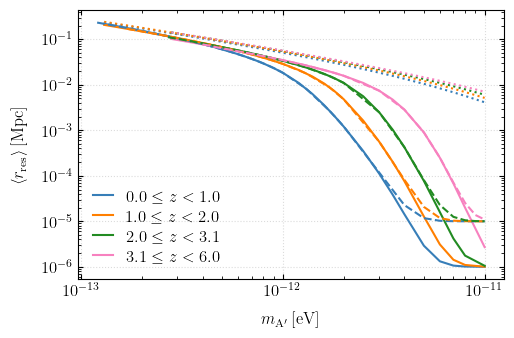

In [10]:
lab = lambda am, bm: r'${:.1f} \leq z < {:.1f}$'.format(am, bm)

fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))

lists, mlists, xdat, ydat = np.load('./data/NFW_rresdat.npy')
cych = cycle(allcolors)
for a1, (zmin, zmax) in enumerate(lists):
    col = next(cych)
    plt.plot(xdat[a1,:], ydat[a1,:], ls=':', color=col)

lists, mlists, xdat, ydat = np.load('./data/gas_rresdat.npy')
cych = cycle(allcolors)
for a1, (zmin, zmax) in enumerate(lists):
    col = next(cych)
    plt.plot(xdat[a1,:], ydat[a1,:], label=lab(zmin, zmax), color=col)

lists, mlists, xdat, ydat = np.load('./data/rresdat.npy')
cych = cycle(allcolors)
for a1, (zmin, zmax) in enumerate(lists):
    col = next(cych)
    plt.plot(xdat[a1,:], ydat[a1,:], ls='--', color=col)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax.set_ylabel(r'$\left< r_{\rm res} \right>[{\rm Mpc}]$')

#ax.set_ylim((1e-5,0.4))
beautify(ax, times=-80)
plt.savefig('./plots/new_rres.pdf', rasterize=True)
plt.show()


In [11]:
if compute_BB_noise:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname == 'Planck':
            elllim = 3000
            nfreqs = 9
            nspec = 4
        else:
            elllim = 3000
            nfreqs = 7
            nspec = 4

        freqs = experiment['freqseV']
        recombination = lensedCMB.T[:nspec,:elllim]
        screening = thom_Screening
        noises = noise(elllim, nfreqs, experiment)

        weights, leftoverdata = get_ILC_BB_noise(elllim, screening, noises, recombination, nspec, nfreqs)
        np.save(BB_weights_path_gas(expname, zreio), weights)
        np.save(BB_ILCnoisePS_path_gas(expname, zreio), leftoverdata)
        print(expname, 'done')

In [12]:
if compute_noise:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname == 'Planck':
            elllim = 4000
            nfreqs = 9
            nspec = 3
        else:
            elllim = ellMax
            nfreqs = 7
            nspec = 3

        for zind, zreio in enumerate(ztype):
            if zind!=1: continue

            for mind, MA in enumerate(dictKey):
                zMin, zMax, rMin, rMax = chooseModel(MA, model)
                zMax = min(zreio, zMax)

                recombination = lensedCMB.T[:nspec,:elllim]

                noises = noise(elllim, nfreqs, experiment)

                varep = 0.
                screening = varep**4. * Screening[zind, mind, :elllim]

                weights, leftoverdata = get_ILC_noise(elllim, units, screening, noises, recombination, experiment, nspec, nfreqs)

                np.save(weights_path_gas(MA, nZs, zMin, zreio, ellMax, expname), weights)
                np.save(ILCnoisePS_path_gas(MA, nZs, zMin, zreio, ellMax, expname), leftoverdata)
        print(expname, 'done')

In [13]:
if get_constr:
    sigmaEpsilonList = np.ones((len(dictKey)+1, 3, 4)) # (#masses sampled, #experiments sampled, #forecast methods)

    for mind, MA in enumerate(dictKey):
        for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
            if expname=='Planck':
                mm, mmm = 10, 3000
            else:
                mm, mmm = 10, 6000

            zind = 1
            zreio = 6.

            ILCnoise = np.load(ILCnoisePS_path_gas(MA, nZs, zMin, zreio, ellMax, expname))
            leftover = ILCnoise[:, :mmm]

            screening = Screening[zind, mind, :, :mmm]

            template = Survey[mind, :mmm]

            # first constraint: CMB screening
        #    sigmaEpsilonList[mind, eind, 0] = sigma_screening_TT(0., fsky[eind], mm, mmm, screening, leftover)
            sigmaEpsilonList[mind, eind, 0] = sigma_screening(0., fsky[eind], mm, mmm, screening, leftover)

            # second constraint: CMB screening cross correlated wih template
            try:
                sigmaEpsilonList[mind, eind, 1] = sigma_screeningVtemplate(TCMB, 0., fsky[eind], mm, mmm, screening, leftover, template)
            except:
                continue

            # third + fourth constraint: bispectrum
            sigmaEpsilonList[mind, eind, 2] = bispTTT[mind, eind]
            sigmaEpsilonList[mind, eind, 3] = bispTEB[mind, eind]

    np.save('./data/constraints.npy', sigmaEpsilonList)
print('Done')

Done


In [14]:
#if get_constr:
if True:
    sigmaEpsilonList_NFW = np.ones((len(dictKey_NFW)+1, 3, 2)) # (#masses sampled, #experiments sampled, #forecast methods)

    for mind, MA in enumerate(dictKey_NFW):
        for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
            if expname=='Planck':
                mm, mmm = 10, 3000
            else:
                mm, mmm = 10, 6000

            zind = 1
            zreio = 6.

            ILCnoise = np.load(ILCnoisePS_path_gas(MA, nZs, zMin, zreio, ellMax, expname))
            leftover = ILCnoise[:, :mmm]

            screening = NFW_Screening[zind, mind, :, :mmm]

            template = NFW_Survey[mind, :mmm]

            # first constraint: CMB screening
        #    sigmaEpsilonList_NFW[mind, eind, 0] = sigma_screening_TT(0., fsky[eind], mm, mmm, screening, leftover)
            sigmaEpsilonList_NFW[mind, eind, 0] = sigma_screening(0., fsky[eind], mm, mmm, screening, leftover)

            # second constraint: CMB screening cross correlated wih template
            try:
                sigmaEpsilonList_NFW[mind, eind, 1] = sigma_screeningVtemplate(TCMB, 0., fsky[eind], mm, mmm, screening, leftover, template)
            except:
                continue

    np.save('./data/constraintsNFW.npy', sigmaEpsilonList_NFW)
print('Done')

/home/dpirvu/DarkPhoton/hmvec-master/compute_power_spectra.py:474: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.7 / (fsky * np.sum(TrF))**0.125


Done


# Plots

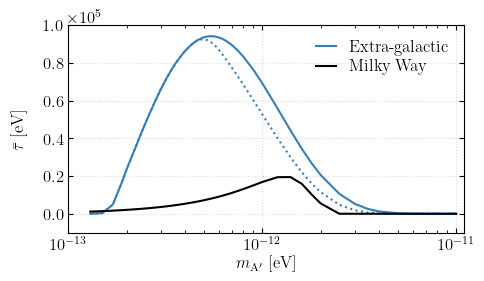

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5., 3.))

plt.plot(dictKey, avtaulist[0,:]/units/np.sqrt(4*np.pi), color=allcolors[0], ls=':')
plt.plot(dictKey, avtaulist[1,:]/units/np.sqrt(4*np.pi), color=allcolors[0], label=r'$\rm Extra$-$\rm galactic$')
plt.plot(dictKey, tauMWlist/units, color='k', ls='-', label=r'$\rm Milky \; Way$')

plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.ylabel(r'$\bar{\tau}  \; [{\rm eV}]$')

ax.set_xlim(1e-13, 1.1e-11)
ax.set_ylim(-1e4, 1e5)
ax.set_xscale('log')
beautify(ax, times=-70)
ax.ticklabel_format(axis='y', style='scientific', scilimits=[0.,0.])
plt.tight_layout()
plt.savefig('./plots/gas_monopoles.pdf')
plt.show()

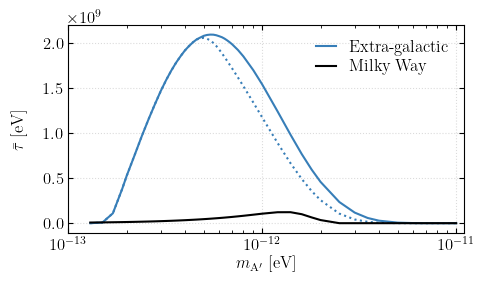

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5., 3.))

plt.plot(dictKey, avtaulist[0,:], color=allcolors[0], ls=':')
plt.plot(dictKey, avtaulist[1,:], color=allcolors[0], label=r'$\rm Extra$-$\rm galactic$')
plt.plot(dictKey, tauMWlist, color='k', ls='-', label=r'$\rm Milky \; Way$')

plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.ylabel(r'$\bar{\tau}  \; [{\rm eV}]$')

ax.set_xlim(1e-13, 1.1e-11)
ax.set_xscale('log')
beautify(ax, times=-70)
plt.tight_layout()
plt.savefig('./plots/gas_monopoles.pdf')
plt.show()

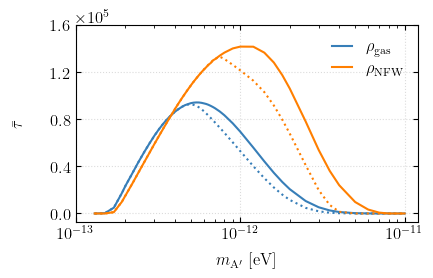

In [17]:
MAMWlimit = np.load('./data/MWmassconstraint.npy')
MAMW_rscalelimit = np.load('./data/MWrscale_massconstraint.npy')
rscaleMW = np.load('./data/MWscaleradius.npy')

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.))

plt.plot(dictKey, avtaulist[0,:]/units/np.sqrt(4*np.pi), color=allcolors[0], ls=':')
plt.plot(dictKey, avtaulist[1,:]/units/np.sqrt(4*np.pi), color=allcolors[0], label=r'$\rho_{\rm gas}$')

plt.plot(dictKey_NFW, NFW_avtaulist[0,:]/units/np.sqrt(4*np.pi), color=allcolors[1], ls=':')
plt.plot(dictKey_NFW, NFW_avtaulist[1,:]/units/np.sqrt(4*np.pi), color=allcolors[1], label=r'$\rho_{\rm NFW}$')

np.save('./data/new_fullmonopole_gas_z6.npy', [dictKey, tauMWlist + avtaulist[1,:]])
np.save('./data/new_fullmonopole_NFW_z6.npy', [dictKey_NFW, tauMWlist + NFW_avtaulist[1,:]])

plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.ylabel(r'$\bar{\tau}$')
ax.set_xscale('log')
ax.set_xlim(1e-13, 1.2e-11)
beautify(ax, times=-100)

a1 = [0, 4e4, 8e4, 12e4, 16e4]
ax.set_yticks(a1)

ax.ticklabel_format(axis='y', style='scientific', scilimits=[0.,0.])

plt.tight_layout()
plt.savefig('./plots/compare_NFW_gas_monopoles.pdf')
plt.show()


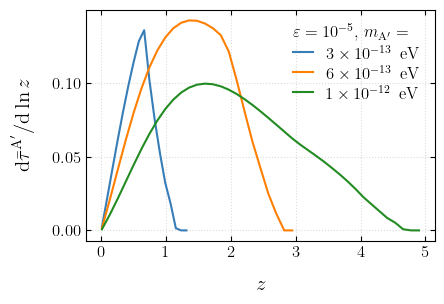

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4.5,3.))
cych = cycle(allcolors)

varep = 1e-5
#ax.text(0.6, 1.1, r'$ \varepsilon = 10^{-5}$', transform=ax.transAxes, verticalalignment='top',\
#       color='black', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0'))

for mind, MA in enumerate(dictKey):
    if mind not in [9, 24, 33]: continue
    iind = next(cych)
    zs6 = zsList[1, mind]
    dat6 = varep**2. * dtaudzlist[1, mind] / xov(baseline)
    cds = np.argwhere(dat6>0.).flatten().tolist()
    cds+= np.arange(cds[-1], cds[-1] + 3).tolist()

    ax.plot(zs6[cds], zs6[cds] * dat6[cds], color=iind, label=sci_notation(MA, 0) + r'\, ${\rm eV}$')

# a1 = ax.get_xticks()[1:-1]
# a1[0] = zs[0]
# ax.set_xticks(a1)
# b1 = np.array([r'${:.3f}$'.format(aa) for aa in a1])
# b1[1:] = np.array([r'${:.0f}$'.format(aa) for aa in a1[1:]])
# ax.set_xticklabels(b1)

ax.set_ylabel(r'${\rm d} \bar{\tau}^{\rm A^{\prime}} / {\rm d} \ln z$', fontsize=15)
ax.set_xlabel(r'$z$', fontsize=15)
beautify(ax, times=-100, bb=(1.,1.), ttl=r'$ \varepsilon = 10^{-5}$'+r'$, \, m_{\rm A^{\prime}} = $')
plt.savefig('./plots/gas_dtaudz.pdf')
plt.show()


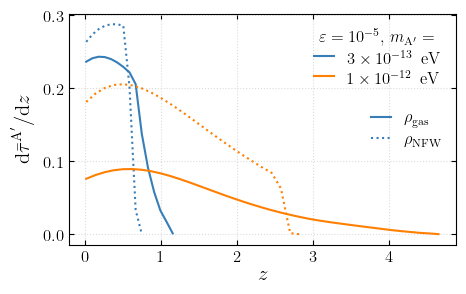

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5., 3.))
cych = cycle(allcolors)

secondary_lines, secondary_labels = [], []
for mind, MA in enumerate(dictKey):
    if mind not in [9, 33]: continue

    zind = 1
    iind = next(cych)

    zs6 = zsList[zind, mind]
    dat6 = dtaudzlist[zind, mind] * varep**2. / xov(baseline)

    cds = np.argwhere(dat6>0.).flatten()
    l1, = ax.plot(zs6[cds], dat6[cds], color=iind, label=sci_notation(MA, 0) + r'\, ${\rm eV}$')

    if mind==9:
        secondary_labels.append(r'$\rho_{\rm gas}$')
        secondary_lines.append(l1)

    zs6 = NFW_zsList[zind, mind]
    dat6 = NFW_dtaudzlist[zind, mind] * varep**2. / xov(baseline)
    cds = np.argwhere(dat6>0.).flatten().tolist()
    cds+= np.arange(cds[-1], cds[-1]+2).tolist()
    l1, = ax.plot(zs6[cds], dat6[cds], color=iind, ls=':')

    if mind==9:
        secondary_labels.append(r'$\rho_{\rm NFW}$')
        secondary_lines.append(l1)

ax.add_artist(plt.legend(secondary_lines, secondary_labels, fancybox=True, framealpha=1, loc='center right', frameon=False, handlelength=1.2, labelspacing=0.3, columnspacing=1))
ax.set_ylabel(r'${\rm d} \bar{\tau}^{\rm A^{\prime}} / {\rm d} z$', fontsize=15)
ax.set_xlabel(r'$z$', fontsize=15)
leg, ax = beautify(ax, times=-60, ttl=r'$ \varepsilon = 10^{-5}$'+r'$, \, m_{\rm A^{\prime}} = $')
leg[0]._legend_box.align = "center"
plt.savefig('./plots/compare_NFW_gas_dtaudz.pdf')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


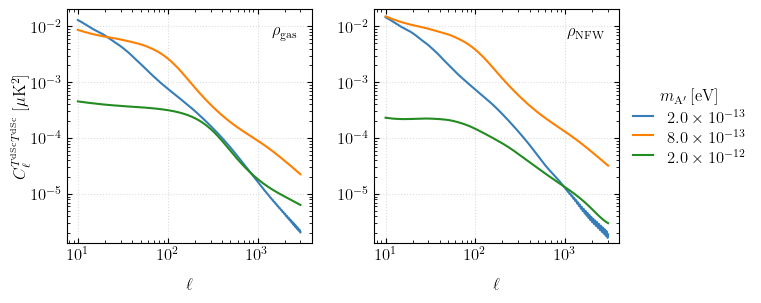

In [20]:
fig = plt.figure(figsize=(7, 3.))
gs = gridspec.GridSpec(1, 9, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4:8])
ax3 = fig.add_subplot(gs[0, 8:])
ax = [ax1, ax2, ax3]
cych = cycle(allcolors)
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

mm, mmm = 10, 3000
ells = np.arange(mm,mmm)
varep = 1e-7

for mind, MA in list(enumerate(dictKey)):
    if mind not in [4, 31, 38]: continue
    iind = next(cych)

    ax[0].plot(ells, TCMB**2. * varep**4. * CellTauTau[1, mind, mm:mmm], color=iind)
    ax[1].plot(ells, TCMB**2. * varep**4. * NFW_CellTauTau[1, mind, mm:mmm], color=iind)
    ax[2].plot(ells, np.ones(mmm-mm), color=iind, label=sci_notation(MA))

ax[0].set_ylabel(r'$C_\ell^{T^{\rm dSc}T^{\rm dSc}}  \; [\mu {\rm K}^2]$')
for aa, axx in enumerate(ax[:-1]):
    axx.set_xlabel(r'$\ell$')
    axx.set_xscale('log')
    axx.set_yscale('log')
    beautify(axx, times=-100, ncol=1, ttl=[r'$\rho_{\rm gas}$', r'$\rho_{\rm NFW}$'][aa], loc=1)
clear_last_coln(ax)
ax[2].legend(fontsize=12, ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$', loc='center', frameon=False, handlelength=1.2, labelspacing=0.3, columnspacing=1)

ytickslocs = ax[0].get_yticks()
ax[1].axes.get_yaxis().set_ticks(ytickslocs)
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))

plt.savefig('./plots/compare_NFW_gas_celltautau.pdf', rasterize=True)
plt.show()


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


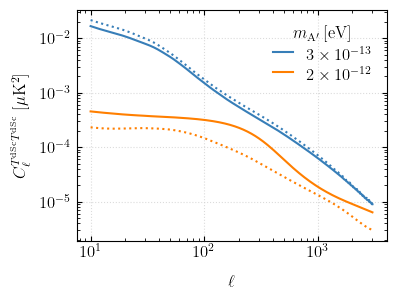

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.))
cych = cycle(allcolors)

mm, mmm = 10, 3000
ells = np.arange(mm,mmm)
varep = 1e-7

for mind, MA in list(enumerate(dictKey)):
    if mind not in [9, 38]: continue
    iind = next(cych)

    ax.plot(ells, TCMB**2. * varep**4. * CellTauTau[1, mind, mm:mmm], color=iind, label=sci_notation(MA, 0))
    ax.plot(ells, TCMB**2. * varep**4. * NFW_CellTauTau[1, mind, mm:mmm], color=iind, ls=':')

ax.set_ylabel(r'$C_\ell^{T^{\rm dSc}T^{\rm dSc}}  \; [\mu {\rm K}^2]$')
for aa, axx in enumerate([ax]):
    axx.set_xlabel(r'$\ell$')
    axx.set_xscale('log')
    axx.set_yscale('log')
    beautify(axx, times=-100, ncol=1, ttl=[r'$\rho_{\rm gas}$', r'$\rho_{\rm NFW}$'][aa], loc=1)
ax.legend(fontsize=12, ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$', loc=1, frameon=False, handlelength=1.2, labelspacing=0.3, columnspacing=1)

plt.savefig('./plots/compare_NFW_gas_celltautau.pdf', rasterize=True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


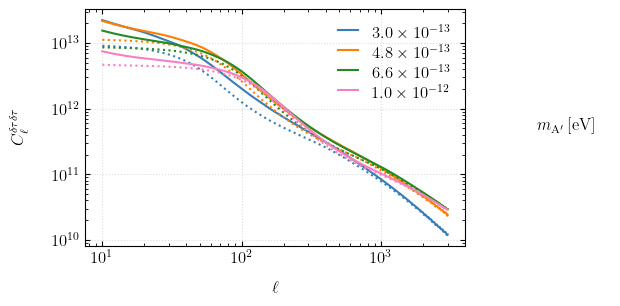

In [22]:
fig = plt.figure(figsize=(6, 3.))
gs = gridspec.GridSpec(1, 4, figure=fig)
ax2 = fig.add_subplot(gs[0, :3])
ax3 = fig.add_subplot(gs[0, 3:])
ax = np.array([ax2, ax3])

plt.tight_layout(pad=1., h_pad=None, w_pad=None, rect=None)

cych = cycle(allcolors)

mm, mmm = 10, 3000
ells = np.arange(mm,mmm)

ct = 0
for mind, MA in list(enumerate(dictKey)):
    if mind in [9, 18, 27, 33]:
        iind = next(cych)
        
        labtot = (r'$C_\ell^{\delta\tau\delta\tau}$' if ct==3 else None)
        lab1h = (r'$C_\ell^{1-{\rm halo}}$' if ct==3 else None)

        ax[0].plot(ells, CellTauTau[1, mind, mm:mmm], color=iind, label=sci_notation(MA))
        ax[0].plot(ells, Cell1Hdata[1, mind, mm:mmm], color=iind, ls=':')
        ct += 1

for aa, axx in enumerate(ax[:-1]):
    axx.set_xlabel(r'$\ell$')
    beautify(axx, times=-100, bb=(1.,1.))
    axx.set_yscale('log')
    axx.set_xscale('log')
    axx.set_ylabel(labtot)
clear_last_coln(ax)
ax[1].legend(fontsize=12, ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$', loc='center', frameon=False, handlelength=1.2, labelspacing=0.3, columnspacing=1)

plt.savefig('./plots/gas_celltautau.pdf')
plt.show()


6e-13


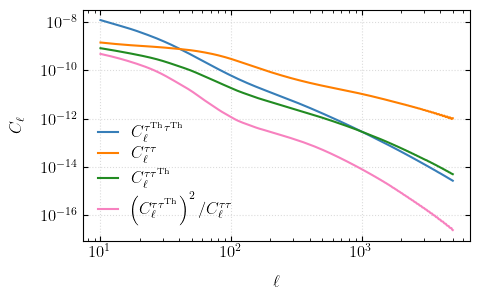

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.))

mm, mmm = 10, 5000
ells = np.arange(mm,mmm)

mind = 24
MA = dictKey[mind]
print(MA)
varep = 3e-6

plt.plot(ells, CellThomThom[mm:mmm], color=allcolors[0], label=r'$C_{\ell}^{\tau^{\rm Th} \tau^{\rm Th}}$')
#plt.plot(ells[:3000-mm], thom_Screening[0, mm:3000], color=allcolors[0], ls=':')

testx = CellTauTau[1, mind, mm:mmm] * varep**4.
plt.plot(ells, testx, color=allcolors[1], label=r'$C_{\ell}^{\tau \tau}$')

testx = cross_CellTTau[mind, mm:mmm] * varep**2.
plt.plot(ells, testx, color=allcolors[2], label=r'$C_{\ell}^{\tau \tau^{\rm Th}}$')

testx = (cross_CellTTau[mind]**2./CellTauTau[1, mind])[mm:mmm]
plt.plot(ells, testx, color=allcolors[3], label=r'$\left(C_{\ell}^{\tau \tau^{\rm Th}}\right)^2/C_{\ell}^{\tau \tau}$')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.xscale('log')
plt.yscale('log')
beautify(ax, times=-100)
plt.savefig('./plots/comparison_corrs.pdf')
plt.show()


/home/dpirvu/DarkPhoton/hmvec-master/compute_power_spectra.py:318: RuntimeWarning: divide by zero encountered in true_divide
  NoiseTT = NellTT / Beams2D
/home/dpirvu/DarkPhoton/hmvec-master/compute_power_spectra.py:318: RuntimeWarning: invalid value encountered in true_divide
  NoiseTT = NellTT / Beams2D
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


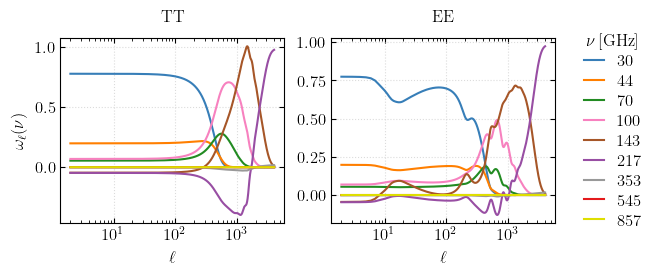

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


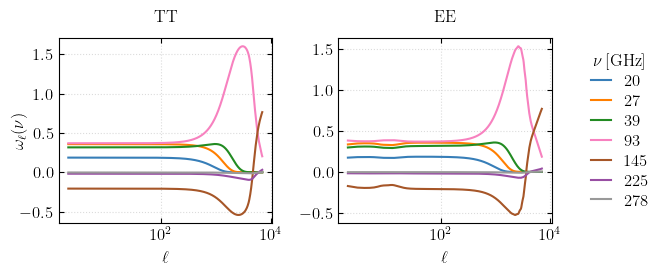

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


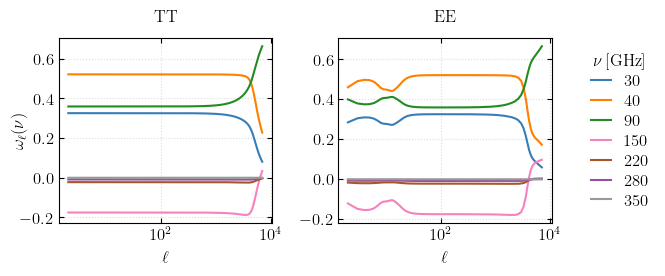

In [24]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
    if expname=='Planck':
        mm, mmm = 2, 4000
        nfreqs = 9
    else:
        mm, mmm = 2, ellMax
        nfreqs = 7
    ells = np.arange(mm,mmm)

    fig = plt.figure(figsize=(6.8, 3.))
    gs = gridspec.GridSpec(1, 9, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4:8])
    ax3 = fig.add_subplot(gs[0, 8:])
    ax = np.array([ax1, ax2, ax3])

    plt.tight_layout(pad=1, h_pad=None, w_pad=None, rect=None)
    mind = 15

    for ii, ij in enumerate(np.arange(len(ax)-1).tolist() + [0]):
        lab0 = ('CMB' if ii==len(ax)-1 else None)
        lab1 = ('Screened CMB' if ii==len(ax)-1 else None)
        lab2 = ('Screening' if ii==len(ax)-1 else None)
        lab3 = ('ILC noise' if ii==len(ax)-1 else None)

        freqs = experiment['freqsGHz']
        Nell  = noise(ellMax, nfreqs, experiment)
        ILCweights = np.load(weights_path_gas(MA, nZs, zMin, zreio, ellMax, expname))

        for jj in range(nfreqs):
            labfreq = (r'${:.0f}$'.format(freqs[jj]) if ii==len(ax)-1 else None)
            ax[ii].plot(ells, ILCweights[ii, mm:mmm, jj], color=allcolors[jj], label=labfreq)

    ax[0].set_ylabel(r'$\omega_\ell(\nu)$')
    for ai, axx in enumerate(ax[:-1]):
        beautify(axx, times=-100)
        axx.set_xlabel(r'$\ell$')
        axx.set_xscale('log')
        axx.set_title([r'\rm TT', r'\rm EE', r'\rm BB'][ai])
    clear_last_coln(ax)
    ax[-1].legend(fontsize=12, ncol=1, title=r'$\nu \, [{\rm GHz}]$', loc='center', frameon=False, handlelength=1.2, labelspacing=0.3, columnspacing=1)

    plt.tight_layout()
    plt.savefig('./plots/weights'+str(expname)+'.pdf')
    plt.show()

In [25]:
if False:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname=='Planck':
            mm, mmm = 10, 3000
            nfreqs = 9
        else:
            mm, mmm = 10, 6000
            nfreqs = 7
        ells = np.arange(mm,mmm)

        fig = plt.figure(figsize=(10, 3))
        gs = gridspec.GridSpec(1, 12, figure=fig)
        ax1 = fig.add_subplot(gs[0, :4])
        ax2 = fig.add_subplot(gs[0, 4:8])
        ax3 = fig.add_subplot(gs[0, 8:])
        ax = np.array([ax1, ax2, ax3])

        plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

        freqs = experiment['freqsGHz']
        Nell  = noise(ellMax, nfreqs, experiment)
        BBILCnoise = np.load(BB_ILCnoisePS_path_gas(expname, zreio))

        varep = 1e-6
        for ii, ij in enumerate(range(3)):
            for mind, MA in enumerate(dictKey):
                ILCnoise = np.load(ILCnoisePS_path_gas(MA, nZs, zMin, zreio, ellMax, expname))

                ax[ii].plot(ells, ILCnoise[ij, mm:mmm], color=allcolors[3])
                ax[ii].plot(ells, varep**4. * Screening[1, mind, ij, mm:mmm], color=allcolors[0])

            ax[ii].plot(ells[:3000-mm], BBILCnoise[ij, mm:3000], color=allcolors[2])
            ax[ii].plot(ells, lensedCMB[mm:mmm, ij], color=allcolors[1])

        for ai, axx in enumerate(ax):
            beautify(axx, times=-100)
            axx.set_xlabel(r'$\ell$')
            axx.set_title([r'\rm TT $[\mu {\rm K}^2]$', r'\rm EE $[\mu {\rm K}^2]$', r'\rm BB $[\mu {\rm K}^2]$'][ai])
            axx.set_xscale('log')
            axx.set_yscale('log')
        plt.tight_layout()
        plt.show()

In [26]:
if False:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname=='Planck':
            mm, mmm = 30, 3000
            nfreqs = 9
        else:
            mm, mmm = 30, 6000
            nfreqs = 7
        ells = np.arange(mm,mmm)

        mind = 33
        MA = dictKey[mind]
        print(MA)

        freqs = experiment['freqsGHz']
        Nell  = noise(ellMax, nfreqs, experiment)
        ILCnoise = np.load(ILCnoisePS_path_gas(MA, nZs, zMin, zreio, ellMax, expname))
        BBILCnoise = np.load(BB_ILCnoisePS_path_gas(expname, zreio))

        fig = plt.figure(figsize=(8.16, 3.6))
        gs = gridspec.GridSpec(1, 9, figure=fig)
        ax1 = fig.add_subplot(gs[0, :4])
        ax2 = fig.add_subplot(gs[0, 4:8])
        ax3 = fig.add_subplot(gs[0, 8:])
        ax = np.array([ax1, ax2, ax3])

        plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

        for ii, ij in enumerate(np.arange(len(ax)-1).tolist() + [0]):
            lab0 = (r'$C_{\ell}^{XX}$' if ii==len(ax)-1 else None)
            lab4 = (r'$C_{\ell}^{X^{\rm dSc} X^{\rm Sc}}$' if ii==len(ax)-1 else None)
            lab5 = (r'$C_{\ell}^{X^{\rm Sc} X^{\rm Sc}}$' if ii==len(ax)-1 else None)
            lab2 = (r'$C_{\ell}^{X^{\rm dSc} X^{\rm dSc}}$' if ii==len(ax)-1 else None)
            lab3 = (r'$\tilde{N}_{\ell}^{X^{\rm dSc} X^{\rm dSc}}$' if ii==len(ax)-1 else None)

            for jj in range(len(freqs)):
                labfreq = (r'${}$ GHz'.format(int(freqs[jj])) if ii==len(ax)-1 else None)
                ax[ii].plot(ells, Nell[ii, mm:mmm, jj], color=allcolors[jj], lw=1, ls=':')

            if ii==0:
                varep = 2e-7
            else:
                varep = 5e-6

            # Make sure everything below is in units of CMB temperature

            ax[ii].plot(ells, varep**4. * Screening[1, mind, ii, mm:mmm], color=allcolors[1], lw=1, ls='-', label=lab2)
            ax[ii].plot(ells, varep**2. * cross_Screening[mind, ii, mm:mmm], color=allcolors[2], lw=1, ls='-', label=lab4)
            ax[ii].plot(ells[:3000-mm], thom_Screening[ii, mm:3000], color=allcolors[3], lw=1, ls='-', label=lab5)
            ax[ii].plot(ells, ILCnoise[ii, mm:mmm],       color=allcolors[5], lw=1, label=lab3)
            ax[ii].plot(ells, lensedCMB[mm:mmm, ii],      color=allcolors[0], lw=1, label=lab0)
          #  ax[ii].plot(ells, BBILCnoise[ii, mm:mmm],     color='k', label=lab3, ls=':')

            ax[ii].legend(title=r'$\varepsilon=$'+sci_notation(varep,0),loc=3, frameon=False)# + r', $m_{\rm A^{\prime}}=$'+r'{}'.format(fmt(MA))+r'$ \, [{\rm eV}]$', loc=1)

        ax[0].set_ylim(1e-11, 10)
        ax[1].set_ylim(1e-12, 1e-2)
        for ai, axx in enumerate(ax[:-1]):
            beautify(axx, times=-100)
            axx.set_xlabel(r'$\ell$')
            axx.set_xscale('log')
            axx.set_yscale('log')
            axx.set_title([r'\rm TT $[\mu {\rm K}^2]$', r'\rm EE $[\mu {\rm K}^2]$', r'\rm BB $[\mu {\rm K}^2]$'][ai])
        clear_last_coln(ax)
        ax[-1].legend(loc='center', ncol=1, frameon=False)

        plt.tight_layout()
        plt.savefig('./plots/comparisons'+str(expname)+'.pdf')
        plt.show()

#### Contour Plot

In [27]:
def existing_limits(ax, bool):
    lssss = [':', '-', '-', '-', '-.']
    jhdata = np.genfromtxt('./data/DPlimits.txt')

    plt.fill_between(jhdata[:,0], jhdata[:,1], np.ones(len(jhdata)), color='darkgray', alpha=0.7)#, label=r'$\rm Caputo \, et \, al. \, 2020$')

    plt.xlim((1e-15, 1e-9))
    plt.ylim((10e-11, 1e-4))
    ax.set_ylabel(r'$\varepsilon$', fontsize=17)
    ax.set_xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$', fontsize=15)
    plt.xscale('log')
    plt.yscale('log')

    if bool:
        xvals, firasz6 = np.load('./data/gas_contour.npy')
        l1 = plt.fill_between(xvals, firasz6, np.ones(len(firasz6)), color=allcolors[0])
        plt.text(1.5e-12, 3e-6, r'$\rm FIRAS$', color='white', weight="bold", rotation=37, fontsize=13)

        beautify(ax, times=-80)
        return l1, ax
    else:
        beautify(ax, times=-80)
        return ax

lssss = ['--', '-', ':', '-.']
constraint = [r'$\rm CMB \, Autocorrelation$', \
              r'${\rm CMB} \times {\rm LSS}$', \
              r'$\left< T^{\rm dSc} \times T^{\rm Sc} \times T^{\rm Sc} \right>$',\
              r'$\left< T^{\rm dSc} \times E^{\rm Sc} \times B^{\rm Sc} \right>$']

#constraint = [r'$\left\langle T^{\rm dSc} T^{\rm dSc} \right\rangle$', \
#              r'$\left\langle T^{\rm dSc} g \right\rangle$', \
#              r'$\left\langle T^{\rm dSc} T^{\rm Sc} T^{\rm Sc} \right\rangle$',\
#              r'$\left\langle T^{\rm dSc} E^{\rm Sc} B^{\rm Sc} \right\rangle$']

sigmaEpsilonList = np.load('./data/constraints.npy')
sigmaEpsilonList_NFW = np.load('./data/constraintsNFW.npy')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


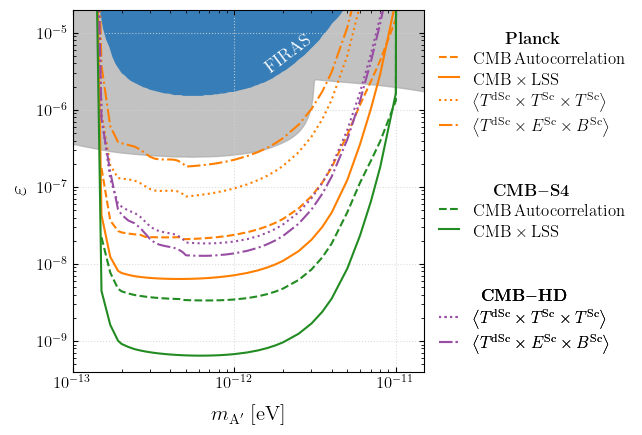

In [28]:
fig, ax = plt.subplots(1,1, figsize = (4.5,4.5))
existing_limits(ax, True)

for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    secondary_lines, secondary_labels = [], []

    for method in range(len(constraint)):
        if eind==1 and method>1: continue
        if eind==2 and method<=1: continue

        if method>1:
            # sigmaEpsilonList[6, eind, method] /= 1.3
            # sigmaEpsilonList[7, eind, method] /= 1.3
            # sigmaEpsilonList[15, eind, method] /= 1.3
            # sigmaEpsilonList[16, eind, method] /= 1.2
            # sigmaEpsilonList[17, eind, method] /= 1.1
            sigmaEpsilonList[5:19, eind, method] = gaussian_filter1d(sigmaEpsilonList[5:19, eind, method], 1.5, mode='nearest')

        col = [allcolors[1], allcolors[2], allcolors[5]][eind]
        lss = lssss[method]

        masslist = np.array(dictKey.tolist() + [1.01e-11])
        l1, = plt.plot(masslist, sigmaEpsilonList[:, eind, method], color=col, ls=lss)

        secondary_labels.append(constraint[method])
        secondary_lines.append(l1)

    leg = ax.add_artist(plt.legend(secondary_lines, secondary_labels, title=expname, \
                             fancybox=True, bbox_to_anchor=[(1.,0.98), (1.,0.56), (1.,0.27)][eind], frameon=False, handlelength=1.2, labelspacing=0.3, columnspacing=1))
    #leg._legend_box.align = "left"

plt.xlim((1e-13, 1.5e-11))
plt.ylim((40e-11, 2e-5))
#plt.ylabel(r'${\rm Coupling \; Constant \;} \varepsilon$')
#plt.xlabel(r'${\rm Dark \; Photon \; Mass \;} m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.ylabel(r'$\varepsilon$')
plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
ax.xaxis.set_label_coords(0.5, -60*0.0015)
plt.tight_layout()
plt.savefig('./plots/gas_contours.pdf')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


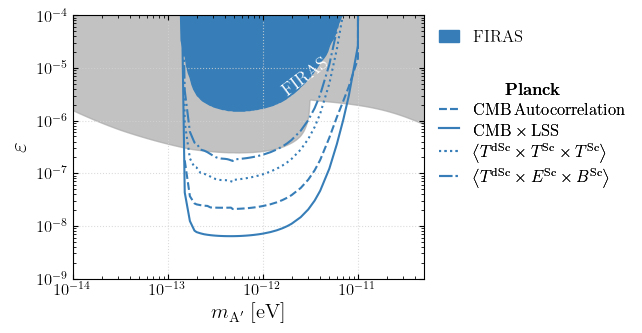

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


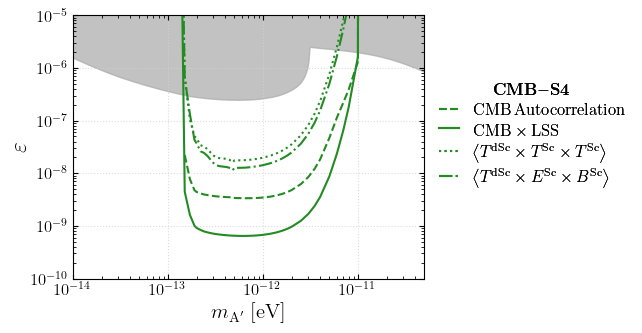

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


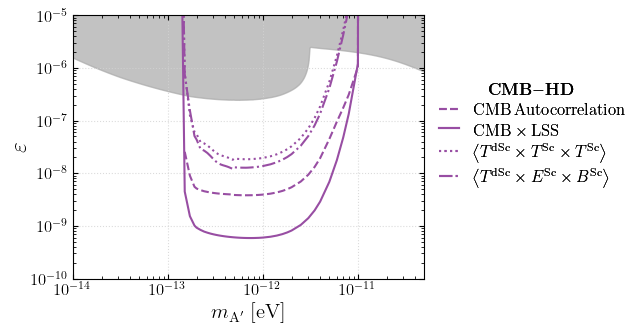

In [29]:
for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    expn = ['Planck', 'CMBS4', 'CMBHD'][eind]
    secondary_lines, secondary_labels = [], []

    fig, ax = plt.subplots(1,1, figsize = (4.5,3.5))
    out = existing_limits(ax, bool=(True if eind==0 else False))
    if eind==0:
        secondary_labels.append(r'$\rm FIRAS$')
        secondary_lines.append(out[0])
    leg = ax.add_artist(plt.legend(secondary_lines, secondary_labels, bbox_to_anchor=(1,1), handlelength=1.2, labelspacing=0.3, columnspacing=1, fancybox=True, frameon=False))
    secondary_lines, secondary_labels = [], []
   
    for method in range(len(constraint)):
    #    if eind==1 and method>1: continue
    #    if eind==2 and method<=1: continue

        if method>1:
    #        sigmaEpsilonList[5:19, eind, method] = gaussian_filter1d(sigmaEpsilonList[5:19, eind, method], 1.5, mode='nearest')
            sigmaEpsilonList[5:19, eind, method] = gaussian_filter1d(sigmaEpsilonList[5:19, eind, method], 1.5, mode='nearest') /1.2

        col = [allcolors[0], allcolors[2], allcolors[5]][eind]
        lss = lssss[method]

        masslist = np.array(dictKey.tolist() + [1.01e-11])
        l1, = plt.plot(masslist, sigmaEpsilonList[:, eind, method], color=col, ls=lss)

        secondary_labels.append(constraint[method])
        secondary_lines.append(l1)

    leg = ax.add_artist(plt.legend(secondary_lines, secondary_labels, bbox_to_anchor=(1,0.8), title=expname, handlelength=1.2, labelspacing=0.3, columnspacing=1, fancybox=True, frameon=False))
    #leg._legend_box.align = "left"

    plt.xlim((1e-14, 5e-11))
    if eind==0:
        plt.ylim((1e-9, 1e-4))
    else:
        plt.ylim((1e-10, 1e-5))
    #plt.ylabel(r'${\rm Coupling \; Constant \;} \varepsilon$')
    #plt.xlabel(r'${\rm Dark \; Photon \; Mass \;} m_{\rm A^{\prime}} \; [{\rm eV}]$')
    plt.ylabel(r'$\varepsilon$')
    plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
    ax.xaxis.set_label_coords(0.5, -60*0.0015)
    plt.tight_layout()
    plt.savefig('./plots/gas_contours'+expn+'.pdf')
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


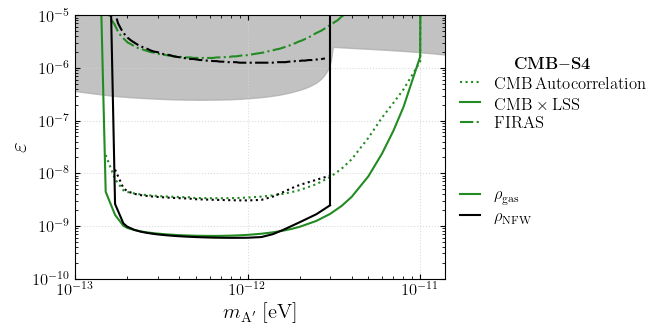

In [31]:
fig, ax = plt.subplots(1,1, figsize = (7.,3.5))
existing_limits(ax, False)

MAMW_rscalelimit = np.load('./data/MWrscale_massconstraint.npy')

masslist = np.array(dictKey.tolist() + [1.01e-11])
nx = np.argmin(np.abs(masslist - MAMW_rscalelimit))

masslist_NFW = np.array(dictKey_NFW.tolist() + [1.01e-11])
nx_NFW = np.argmin(np.abs(masslist_NFW - MAMW_rscalelimit))

lssss2 = [':', '-', '-.']
secondary_lines, secondary_labels = [], []
for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    if expname != r'$\rm \mathbf{CMB{-}S4}$': continue
    col = [allcolors[1], allcolors[2]][eind]

    for method in range(3):
        if method!=2:
            l1, = plt.plot(masslist, sigmaEpsilonList[:, eind, method], color=col, ls=lssss2[method], label=constraint[method])
        else:
            xvals, firasz6 = np.load('./data/gas_contour.npy')
            
            plt.plot(xvals, firasz6, color=col, ls=lssss2[method], label=r'\rm FIRAS')

        if method==1:
            secondary_labels.append(r'$\rho_{\rm gas}$')
            secondary_lines.append(l1)

for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    if expname != r'$\rm \mathbf{CMB{-}S4}$': continue

    for method in range(3):

        if method!=2:
            sigmaEpsilonList_NFW[nx_NFW+1:, eind, method] = 1e-3
            l1, = plt.plot(masslist[:nx_NFW+1], sigmaEpsilonList_NFW[:nx_NFW+1, eind, method], color='k', ls=lssss2[method])

            if method==1:
                plt.plot(masslist[nx_NFW]*np.ones(10), np.linspace(sigmaEpsilonList_NFW[nx_NFW, eind, method],1e-3,10), 'k-')
        else:
            xvals, firasz6 = np.load('./data/NFW_contour.npy')
            nxx = np.argmin(np.abs(xvals - MAMW_rscalelimit))
            plt.plot(xvals[:nxx+1], firasz6[:nxx+1], color='k', ls=lssss2[method])

        if method==1:
            secondary_labels.append(r'$\rho_{\rm NFW}$')
            secondary_lines.append(l1)

ax.add_artist(plt.legend(secondary_lines, secondary_labels, fancybox=True, bbox_to_anchor=(1.,0.4), frameon=False, handlelength=1.2, labelspacing=0.3, columnspacing=1))

leg = plt.legend(title=r'$\rm \mathbf{CMB{-}S4}$', fancybox=True, bbox_to_anchor=(1.,.9), frameon=False, handlelength=1.2, labelspacing=0.3, columnspacing=1)
#leg._legend_box.align = "left"
ax.xaxis.set_label_coords(0.5, -60*0.0015)
plt.xlim((1e-13, 1.4e-11))
plt.ylim((10e-11, 1e-5))
plt.tight_layout()

plt.savefig('./plots/gasvsNFW_contours.pdf')
plt.show()
